<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/resp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Response surface model

In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from numpy.random import rand

Assume that you have found out that the temperature should be about 25C, pH about 8.0, and the amount of enzyme about 19 mg. Define an experimental domain with the centre point according to the values above (or your own best point, and with a range for each variable that is 10% of the full range given above

In [2]:
def experiment(X):
  Xspan=[25, 4, 20]
  Xmin=[20, 5, 5]
  Xscale=[]
  for a, b,c in zip(X, Xmin,Xspan):
    Xscale.append((a-b)/c)

  koeff=[[0.643, -0.686, -0.341], [0.704, 0.704, -0.087], [0.3, -0.184, 0.936]]
  koeff=np.array(koeff)

  max1=[0.21, 0.77, 0.68]
  cent1=[]
  for a,b in zip(Xscale, max1):
    cent1.append(a-b)

  koord1=np.matmul(koeff.T, cent1)
  max2=[0.73, 0.42, 0.19]
  cent2=[]
  for a, b in zip(Xscale, max2):
    cent2.append(a-b)

  Resp1=8/(0.1+2*koord1[0]*koord1[0]+0.5*koord1[1]*koord1[1]+0.9*koord1[2]*koord1[2])
  Resp2=1/(0.05+10*(np.sum(np.square(cent2), axis=0)))
  Resp=(15+Resp1+Resp2)+0.1*(rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand())
  return Resp


In [30]:
# first try
#create list of data for high and low.
dat = [('T',20, 21.5, 23),
        ('p',5, 5.2, 5.4),
        ('A',15, 15.8, 16.6)]

In [23]:
# second try
max=1
#create list of data for high and low.
dat = [('T',March_real.iloc[max].Temperature-0.5, March_real.iloc[max].Temperature, March_real.iloc[max].Temperature+0.5),
        ('p', March_real.iloc[max].pH-0.5, March_real.iloc[max].pH,  March_real.iloc[max].pH+0.5),
        ('A',March_real.iloc[max].Amount-0.5, March_real.iloc[max].Amount, March_real.iloc[max].Amount+0.5 )]

In [31]:
inputs_labels = {'T' : 'Temperature',
                 'p' : 'pH',
                 'A':'Amount'}



# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df

,low,center,high,label
index,,,,
T,20,21.5,23.0,Temperature
p,5,5.2,5.4,pH
A,15,15.8,16.6,Amount


In [32]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
T,20,21.5,23.0,Temperature,-1.0,0.0,1.0
p,5,5.2,5.4,pH,-1.0,0.0,1.0
A,15,15.8,16.6,Amount,-1.0,0.0,1.0


In [33]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1], [-1,1]))
encoded_inputs
for i in range(0,1):
    encoded_inputs.append((0,0,0))
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1),
 (0, 0, 0)]

In [34]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['T','p', 'A']
results

,T,p,A
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1
8,0,0,0


In [35]:
def parse_values(x):
    if x < 2:
       return x * 10
    elif x < 4:
       return x ** 2
    else:
       return x + 10

real_experiment = results
var_labels = []
for var in ['T','p', 'A']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']),
        axis=1)



print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Temperature,pH,Amount
0,20.0,5.0,15.0
1,23.0,5.0,15.0
2,20.0,5.4,15.0
3,23.0,5.4,15.0
4,20.0,5.0,16.6
5,23.0,5.0,16.6
6,20.0,5.4,16.6
7,23.0,5.4,16.6
8,21.5,5.2,15.8


In [36]:
resp=[]
for i in range(len(real_experiment.index)):
   X=[real_experiment.Temperature[i], real_experiment.pH[i],real_experiment.Amount[i]]
   resp.append(experiment(X))

results['y']= resp
results

,T,p,A,Temperature,pH,Amount,y
0,-1,-1,-1,20.0,5.0,15.0,21.647232
1,1,-1,-1,23.0,5.0,15.0,22.722286
2,-1,1,-1,20.0,5.4,15.0,22.970430
3,1,1,-1,23.0,5.4,15.0,24.562063
4,-1,-1,1,20.0,5.0,16.6,22.010079
5,1,-1,1,23.0,5.0,16.6,23.133190
6,-1,1,1,20.0,5.4,16.6,23.453017
7,1,1,1,23.0,5.4,16.6,24.962269
8,0,0,0,21.5,5.2,15.8,23.040920


In [37]:
results['y'].sort_values(ascending=False)
order=results['y'].sort_values(ascending=False).index
order

Index([7, 3, 6, 5, 8, 2, 1, 4, 0], dtype='int64')

In [44]:
y1 = results['y']
xlabs=['T','p','A']
x = results[xlabs]
x = sm.add_constant(x)

res1 = smf.ols(formula='y ~ T + p + A', data=results).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     121.9
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           4.28e-05
Time:                        10:50:24   Log-Likelihood:                 6.5304
No. Observations:                   9   AIC:                            -5.061
Df Residuals:                       5   BIC:                            -4.272
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.1668      0.052    442.295      0.000      23.032      23.301
T              0.6624      0.056     11.923      0.000       0.520       0.805
p              0.8044      0.056     14.479      0.000       0.662       0.947
A              0.2071      0.056      3.727      0.014       0.064       0.350
==============================================================================
Omnibus:                        6.646   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                1.312
Skew:                           0.187   Prob(JB):                        0.519
Kurtosis:                       1.167   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This leaves with the first order model: ybar = 23.1511 + 0.6881T + 0.7681p +0.3016A  

So, now, for any t and T, we can predict y. This fits a flat surface and it tells us that the predicted y is a function of T, pH and A and the coefficients are the gradient of this function. We are working in coded variables, which means that the coefficients are unitless.

If we move 0.6881 in the direction of T and then 0.7681 and 0.3016 in the direction of pH and A, this will be the direction of steepest ascent. All we know is that this flat surface is one side of the "hill" forming our maxima.

With the method of steepest descent, we can now start marching up the hill taking additional measurements at each (T,pH, A) until the response starts to decrease. If we start at 0 (in coded units), then we can do series of single experiments on this path up the hill of the steepest ascent. If swe do this at a step size of t=1, then:



In [47]:
Origin = [results['T'].iloc[order[0]], results['p'].iloc[order[0]], results['A'].iloc[order[0]]]
coeff= res1.params
delta=[coeff[1]/coeff[1],coeff[2]/coeff[1],coeff[3]/coeff[1] ]
marchT=[Origin[0]];marchp=[Origin[1]];marcha=[Origin[2]]

for i in range(0,4):
    marchT.append(Origin[0]+(i+1)*delta[0])
    marchp.append(Origin[1]+(i+1)*delta[1])
    marcha.append(Origin[1]+(i+1)*delta[2])

March=pd.DataFrame({'T':marchT, 'p':marchp, 'A':marcha})
ypred=res1.predict(March)

March['ypred']=ypred


# Lets do the real experiment
#assume we take steps in T

Origin_real=[results['Temperature'].iloc[order[0]], results['pH'].iloc[order[0]], results['Amount'].iloc[order[0]]]
marchT_real=[];marchp_real=[];marcha_real=[]
for i in range(len(March)):
    marchT_real.append(Origin_real[0]+(i+1)*delta[0])
    marchp_real.append(Origin_real[1]+(i+1)*delta[1])
    marcha_real.append(Origin_real[2]+(i+1)*delta[2])

March_real=pd.DataFrame({'Temperature':marchT_real, 'pH':marchp_real, 'Amount':marcha_real})

resp=[]
for i in range(len(March_real)):
   X=[March_real.Temperature[i], March_real.pH[i],March_real.Amount[i]]
   resp.append(experiment(X))

March['y_real']= resp
March



<ipython-input-47-6700d3f4a22c>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta=[coeff[1]/coeff[1],coeff[2]/coeff[1],coeff[3]/coeff[1] ]


,T,p,A,ypred,y_real
0,1.0,1.000000,1.000000,24.840655,40.132041
1,2.0,2.214367,1.312612,26.544574,86.017090
2,3.0,3.428734,1.625223,28.248492,60.007788
3,4.0,4.643101,1.937835,29.952410,30.713750
4,5.0,5.857467,2.250446,31.656329,22.248896


<Axes: >

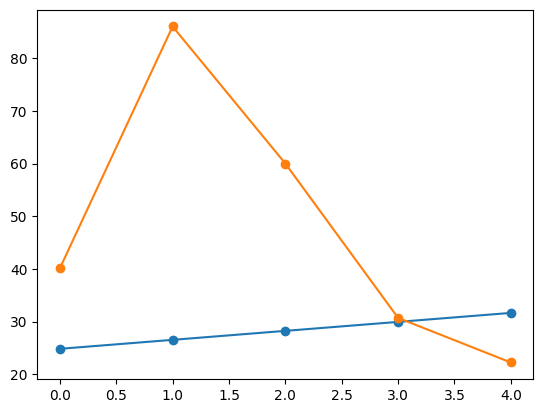

In [48]:
March['ypred'].plot(marker='o')
March['y_real'].plot(marker='o')


In [14]:
March['y_real'].sort_values(ascending=False)

,y_real
1,90.292163
2,50.156999
0,42.174957
3,27.066920


In [15]:
March_real

,Temperature,pH,Amount
0,24.0,6.709647,16.898962
1,25.0,8.019294,17.197923
2,26.0,9.328941,17.496885
3,27.0,10.638588,17.795846
